# 1. Install relevant libraries

In [1]:
!pip install torch-explain

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

# 2. Import relevant libraries

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch_explain as te
from torch_explain import datasets

# 3. Load the dataset and feed it into the Data Loader

In [3]:
# Dataset loaded
x, c, y = datasets.xor(500)

In [4]:
# Will use this class in order to provide batches for DataLoader
class XORdataset(Dataset):
    def __init__(self, x, c, y):
        self.x = x
        self.c = c
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.c[idx], self.y[idx]

In [5]:
def createDataLoader(x_dataset, c_dataset, y_dataset, batch_size):
  # Using the datasets generated above, split it into training and testing data
  x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(x_dataset, c_dataset, y_dataset, test_size=0.33, random_state=42)

  # Create instances of the XORdataset for training and testing
  train_dataset = XORdataset(x_train, c_train, y_train)
  test_dataset = XORdataset(x_test, c_test, y_test)

  # Define the batch size
  loader_batch_size = batch_size

  # Create DataLoader instances for training and testing
  train_loader = DataLoader(train_dataset, batch_size=loader_batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=loader_batch_size, shuffle=False)

  return train_loader, test_loader

# 4. Initialise Model

For joint, the model class is different compared to independent and sequential. The whole point is that the concept and label predictor should be trained together. The model is **trained jointly** to optimise both concept and final output predictions simultaneously. Losses for concept and final predictions are combined using a lambda coefficient, encouraging accurate predictions of both.




In [6]:
class model(nn.Module):
    def __init__(self, input_size, concept_hidden_dim, concept_size, label_hidden_dim, output_size):
        super(model, self).__init__()
        # Layers to predict concepts
        self.linear1 = nn.Linear(input_size, concept_hidden_dim)
        self.linear2 = nn.Linear(concept_hidden_dim, concept_size)

        # Layers to predict final output from concepts
        self.linear3 = nn.Linear(concept_size, label_hidden_dim)
        self.linear4 = nn.Linear(label_hidden_dim, output_size)

    def forward(self, x):
        # First two layers for concept prediction
        x_c = self.linear1(x)
        x_c = F.relu(x_c)
        x_c = self.linear2(x_c) # x_c on LHS is the "intermediate output"
        intermediate_probability = torch.sigmoid(x_c)

        x = F.relu(x_c)
        # Second two layers for label prediction
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        final_probability = torch.sigmoid(x)  # Sigmoid activation for binary classification

        return intermediate_probability, final_probability

# 5. Train the Model

In [7]:
def train(x_size, c_size, y_size, c_dimension, y_dimension, learning_rate, lamda, epochs, train_loader, test_loader):
    torch.manual_seed(25)

    x_to_y = model(x_size, c_dimension, c_size, y_dimension, y_size)

    criterion = nn.BCELoss() # Binary cross-entropy loss
    x_to_y_optimiser = torch.optim.SGD(x_to_y.parameters(), lr = learning_rate)

    # Initialising useful lists
    # For training
    x_to_c_loss_values, c_to_y_loss_values, total_loss_values = [], [], []
    x_to_c_predictions, c_to_y_predictions = [], []
    epochs_count = []
    ground_truth_c, ground_truth_y = [], []
    x_to_c_accuracy_values, c_to_y_accuracy_values = [], []
    # For testing
    x_to_c_test_loss_values, c_to_y_test_loss_values, total_test_loss_values = [], [], []
    x_to_c_test_accuracy_values, c_to_y_test_accuracy_values = [], []

    for epoch in epochs:
        epochs_count.append(epoch)

        # Training Loop ==========================================================
        # Instantiating values for training
        running_x_to_c_loss, running_c_to_y_loss, running_total_loss = 0.0, 0.0, 0.0
        x_to_c_correct, c_to_y_correct, total_samples = 0, 0, 0

        for i, batch in enumerate(train_loader):
            x, c, y = batch

            # Add ground truths from the dataset
            ground_truth_c.append(c)
            ground_truth_y.append(y)

            # Forward pass through x_to_y
            x = x.to(x_to_y.linear1.weight.dtype)  # ensures data type of input tensor x matches data type of weights of the first linear layer
            predicted_c, predicted_y = x_to_y(x)

            x_to_c_predictions.append(predicted_c.detach().numpy())
            c_to_y_predictions.append(predicted_y.detach().numpy())

            c_loss = criterion(predicted_c, c.float())
            y_loss = criterion(predicted_y, y.float())

            # Combined loss
            total_loss = c_loss + lamda * y_loss

            # Zero gradients for optimiser
            x_to_y_optimiser.zero_grad()

            # Backward pass and optimisation for combined loss
            total_loss.backward()
            x_to_y_optimiser.step()

            # Accumulate loss values
            running_x_to_c_loss += c_loss.item()
            running_c_to_y_loss += y_loss.item()
            running_total_loss += total_loss.item()

            # Accumulate correct predictions
            x_to_c_correct += ((predicted_c.round() == c).sum(dim=1) == 2).float().sum().item()
            c_to_y_correct += (predicted_y.round() == y).float().sum().item()

            total_samples += len(y)

        x_to_c_loss_values.append(running_x_to_c_loss / len(train_loader))
        c_to_y_loss_values.append(running_c_to_y_loss / len(train_loader))
        total_loss_values.append(running_total_loss / len(train_loader))
        x_to_c_accuracy_values.append(x_to_c_correct / total_samples)
        c_to_y_accuracy_values.append(c_to_y_correct / total_samples)

        # Testing Loop ===========================================================
        x_to_y.eval()

        # Instantiating values for testing
        running_x_to_c_test_loss, running_c_to_y_test_loss, running_total_test_loss = 0.0, 0.0, 0.0
        x_to_c_test_correct, c_to_y_test_correct, total_test_samples = 0, 0, 0

        with torch.no_grad():
          for x, c, y in test_loader:
              # Forward pass through x_to_y
              predicted_c, predicted_y = x_to_y(x.to(dtype=x_to_y.linear1.weight.dtype))

              c_loss = criterion(predicted_c, c.float())
              y_loss = criterion(predicted_y, y.float())

              total_loss = c_loss + lamda * y_loss

              # Accumulate loss values for testing
              running_x_to_c_test_loss += c_loss.item()
              running_c_to_y_test_loss += y_loss.item()
              running_total_test_loss += total_loss.item()

              # Accumulate correct predictions for testing
              x_to_c_test_correct += ((predicted_c.round() == c).sum(dim=1) == 2).float().sum().item()
              c_to_y_test_correct += (predicted_y.round() == y).float().sum().item()

              total_test_samples += len(y)

        x_to_c_test_loss_values.append(running_x_to_c_test_loss / len(test_loader))
        c_to_y_test_loss_values.append(running_c_to_y_test_loss / len(test_loader))
        total_test_loss_values.append(running_total_test_loss / len(test_loader))
        x_to_c_test_accuracy_values.append(x_to_c_test_correct / total_test_samples)
        c_to_y_test_accuracy_values.append(c_to_y_test_correct / total_test_samples)


    return x_to_y, x_to_c_loss_values, c_to_y_loss_values, total_loss_values, x_to_c_predictions, c_to_y_predictions, epochs_count, ground_truth_c, ground_truth_y, x_to_c_accuracy_values, c_to_y_accuracy_values, x_to_c_test_loss_values, c_to_y_test_loss_values, total_test_loss_values, x_to_c_test_accuracy_values, c_to_y_test_accuracy_values

In [8]:
# TRAINING
# Parameters
x_size = x.shape[1]
c_size = c.shape[1]
y_size = y.shape[1]
c_dimension = 10
y_dimension = 10
learning_rate = 0.01
batch_size = 5
lamda = 0.3
epochs = list(range(400))  # Training for N number of epochs

# Create the required data
train_loader, test_loader = createDataLoader(x, c, y, batch_size)

# Run the training
x_to_y, x_to_c_loss_values, c_to_y_loss_values, total_loss_values, x_to_c_predictions, c_to_y_predictions, epochs_count, ground_truth_c, ground_truth_y, x_to_c_accuracy_values, c_to_y_accuracy_values, x_to_c_test_loss_values, c_to_y_test_loss_values, total_test_loss_values, x_to_c_test_accuracy_values, c_to_y_test_accuracy_values = train(
    x_size, c_size, y_size, c_dimension, y_dimension, learning_rate, lamda, epochs, train_loader, test_loader
)

# 6. Training Evaluation

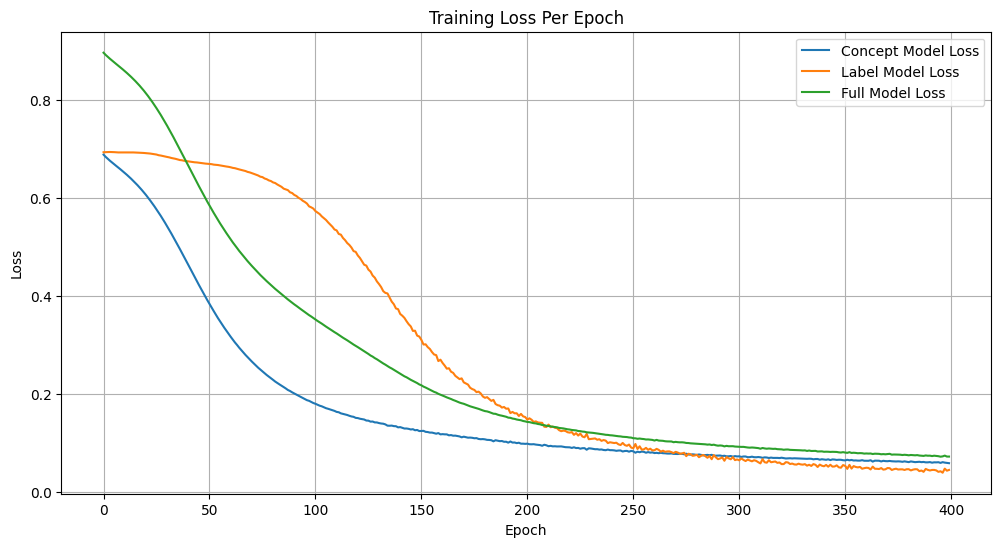

In [9]:
# RESULTS

# Training loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Concept Model Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Label Model Loss')
plt.plot(epochs_count, total_loss_values, label='Full Model Loss')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

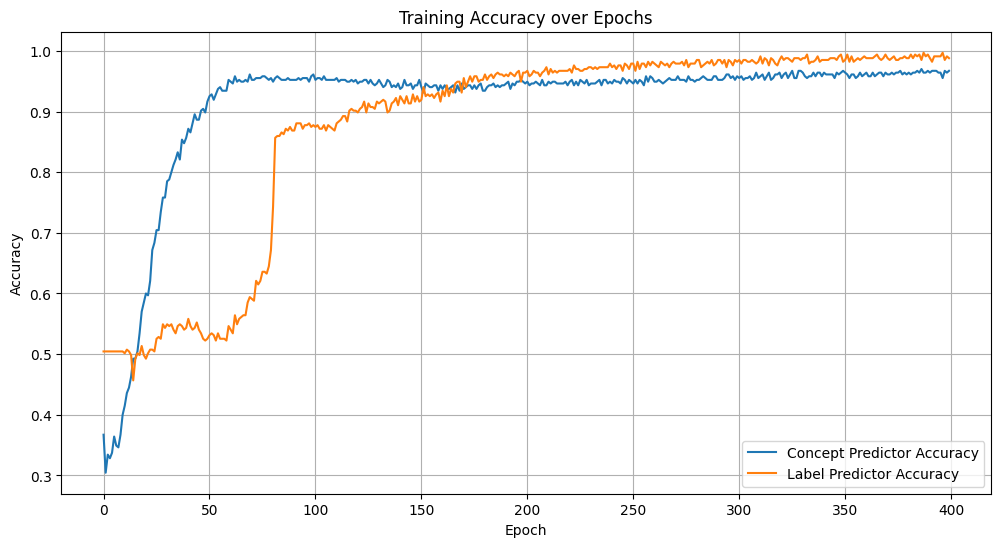

In [10]:
# Training accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_accuracy_values, label='Concept Predictor Accuracy')
plt.plot(epochs_count, c_to_y_accuracy_values, label='Label Predictor Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Evaluation metrics

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model_metrics(predictions, ground_truth, loss_values):
    """
    Evaluate metrics for the model predictions against the ground truth labels.

    Args:
    predictions (list of np.array): List of predictions from each epoch (each array corresponds to an epoch).
    ground_truth (list of torch.Tensor): List of ground truth labels.
    loss_values (list): List of loss values for each epoch.

    Returns:
    dict: A dictionary containing evaluated metrics.
    """
    # Convert predictions and ground truths to a single array for evaluation
    predictions_flat = np.concatenate(predictions, axis=0)
    ground_truth_flat = np.concatenate([gt.numpy() for gt in ground_truth], axis=0)

    # Binarize predictions for accuracy, precision, recall calculation
    predictions_binarized = (predictions_flat > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(ground_truth_flat, predictions_binarized)
    precision = precision_score(ground_truth_flat, predictions_binarized, average='macro', zero_division=1)
    recall = recall_score(ground_truth_flat, predictions_binarized, average='macro')
    f1 = f1_score(ground_truth_flat, predictions_binarized, average='macro')
    mean_loss = np.mean(loss_values)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "mean_loss": mean_loss
    }

x_to_c_metrics = evaluate_model_metrics(x_to_c_predictions, ground_truth_c, x_to_c_loss_values)
print("x_to_c model metrics:", x_to_c_metrics)

c_to_y_metrics = evaluate_model_metrics(c_to_y_predictions, ground_truth_y, c_to_y_loss_values)
print("c_to_y model metrics:", c_to_y_metrics)

x_to_c model metrics: {'accuracy': 0.913910447761194, 'precision': 0.9212173562996472, 'recall': 0.9958082821550701, 'f1_score': 0.9569369504546027, 'mean_loss': 0.17258445970182976}
c_to_y model metrics: {'accuracy': 0.8727164179104477, 'precision': 0.8767145405435426, 'recall': 0.8722576103229487, 'f1_score': 0.8722711185520132, 'mean_loss': 0.2866763711006859}


# 7. Test Evaluation



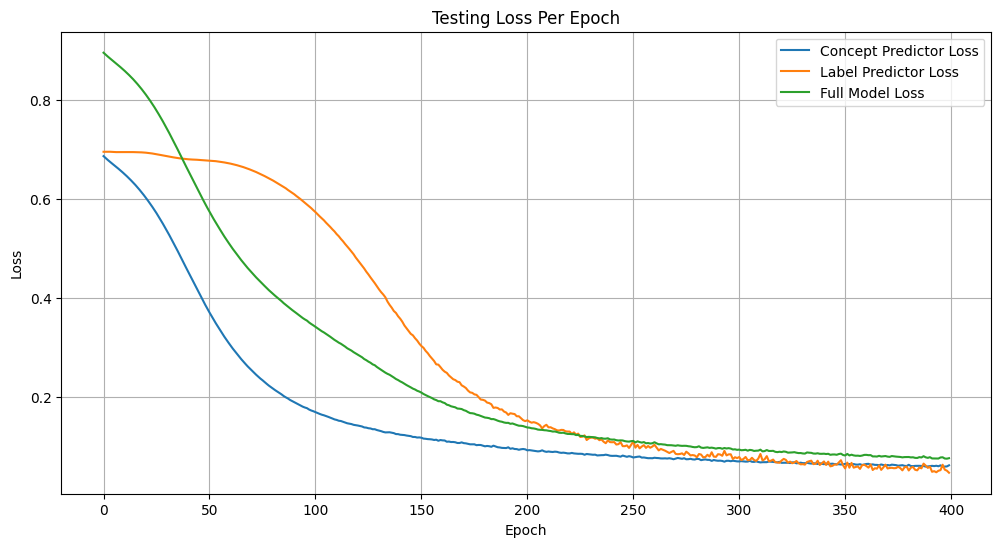

In [12]:
# RESULTS

# Testing loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_test_loss_values, label='Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_test_loss_values, label='Label Predictor Loss')
plt.plot(epochs_count, total_test_loss_values, label='Full Model Loss')
plt.title('Testing Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

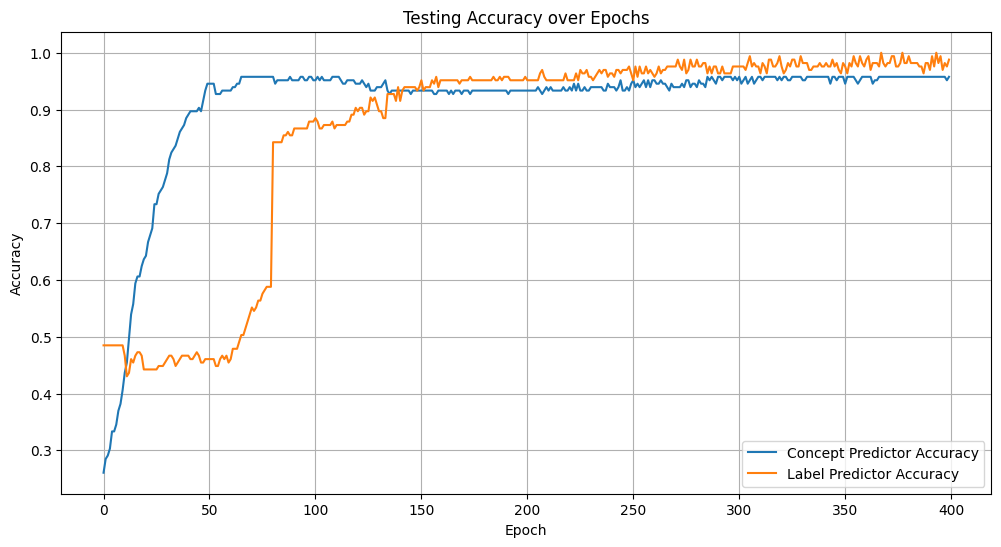

In [13]:
# Testing accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_test_accuracy_values, label='Concept Predictor Accuracy')
plt.plot(epochs_count,c_to_y_test_accuracy_values, label='Label Predictor Accuracy')
plt.title('Testing Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def test_joint_model(x_to_y, test_loader):
    criterion = nn.BCELoss()

    x_to_y.eval()

    test_losses = []
    all_concept_predictions = []
    all_output_predictions = []
    all_output_ground_truths = []

    with torch.no_grad():
        for x, c, y in test_loader:
            # Ensure input is in the right dtype
            x = x.to(dtype=x_to_y.linear1.weight.dtype)

            # Forward pass through the joint model
            predicted_c, predicted_y = x_to_y(x)

            # Compute loss for the output predictions
            output_loss = criterion(predicted_y, y.float())
            test_losses.append(output_loss.item())

            # Store predictions and actual values for metrics calculations
            all_concept_predictions.extend(predicted_c.numpy())
            all_output_predictions.extend(predicted_y.numpy())
            all_output_ground_truths.extend(y.numpy())

    # Evaluate output predictions metrics
    output_predictions_binarized = (np.array(all_output_predictions) > 0.5).astype(int)
    ground_truth_flat = np.array(all_output_ground_truths)

    accuracy = accuracy_score(ground_truth_flat, output_predictions_binarized)
    precision = precision_score(ground_truth_flat, output_predictions_binarized, average='macro', zero_division=1)
    recall = recall_score(ground_truth_flat, output_predictions_binarized, average='macro')
    f1 = f1_score(ground_truth_flat, output_predictions_binarized, average='macro')
    mean_loss = np.mean(test_losses)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "mean_loss": mean_loss
    }


test_metrics = test_joint_model(x_to_y, test_loader)
print("test_metrics:", test_metrics)


test_metrics: {'accuracy': 0.9878787878787879, 'precision': 0.9878676470588236, 'recall': 0.9878676470588236, 'f1_score': 0.9878676470588236, 'mean_loss': 0.04788831923382752}
